## 목차

- [라이브러리 설치](#install_libraries)

- [레이더 강수량 자료 다운로드](#download_radar_rain_data)

- [강수세기 분포도 표출](#plot_rain_rate_distribution)

## 라이브러리 설치<a id='install_libraries'></a>

In [1]:
# API 요청을 위한 requests 라이브러리와 
# 분포도 표출을 위한 matplotlib 라이브러리,
# 이미지 및 점의 좌표계 변환을 위한 rasterio, pyproj 라이브러리와
# 지도를 표출하기 위한 folium 라이브러리를 설치합니다.
%pip install requests matplotlib rasterio pyproj folium

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 레이더 강수량 자료 다운로드<a id='download_radar_rain_data'></a>

기상청 API허브에 회원가입 후 자신의 인증키를 사용하여 API 요청을 할 수 있습니다.

API 인증키를 코드상에 직접 남겨 사용하는 방식은 다른 사람에게 코드를 공유할때 인증키가 노출되는 문제가 생길 수 있습니다.

따라서 인증키를 환경변수로 등록하여 코드상에 노출되지 않도록 사용하는 것이 바람직합니다.

In [2]:
import os # 환경변수를 불러오는 표준 라이브러리

# 바람직하지 않은 방법
# my_api_key = 'MY_PRIVATE_API_AUTHENTICATE_KEY'

# 인증키를 'myapikey'라는 이름의 환경변수로 미리 등록해놓은 뒤 이를 불러와서 사용합니다.
my_api_key = os.environ['myapikey']

In [3]:
import requests # API 요청을 보내고 받는 라이브러리

# 레이더 합성자료 강수량 API url
api_url = 'https://apihub.kma.go.kr/api/typ04/url/rdr_cmp_file.php'

# 요청인자로 자료시간, 자료형태, 합성종류가 있습니다.

# 1. 자료시간을 년월일시분으로 입력합니다.
# 레이더 자료는 매 5분 단위로 입력할 수 있습니다.
time = '202208082000'

# 2. 자료 형태를 입력합니다.
# 이진파일(bin)과 이미지(img)를 입력할 수 있습니다.
data_type = 'bin'

# 3. 합성 종류를 입력합니다.
# 이진파일 요청의 경우 cpp, ppi. cmx, hsr, hsp를 입력할 수 있습니다.
cmp_type = 'hsp'

# API 요청인자들을 묶어 dictionary로 정의합니다.
api_parameters = {
    'tm': time,
    'data': data_type,
    'cmp': cmp_type,
    'authKey': my_api_key
}

# API허브에서는 이진 파일을 gz형식으로 압축하여 제공합니다.
file_name = f'RDR_CMP_{cmp_type.upper()}_PUB_{time}.bin.gz'

# 저장된 파일이 없는 경우에만 API를 요청해 파일을 다운로드합니다.
if not os.path.exists(file_name):
    # API 요청인자와 함께 API 요청
    response = requests.get(api_url, params=api_parameters)

    # 잘못된 응답을 받거나 짧은 에러메세지를 응답으로 받은 경우 에러 메세지 출력
    if response.status_code != 200 or len(response.content) < 500:
        raise requests.RequestException(
            response.content.decode('utf-8')
        )
    else:
        # 그 외의 올바른 응답에 대해서만 파일로 저장합니다.
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f'{file_name} 파일 다운로드 완료')

RDR_CMP_HSP_PUB_202208082000.bin.gz 파일 다운로드 완료


다운로드 받은 레이더 합성자료에 관한 참고자료는 [이곳](https://apihub.kma.go.kr/getAttachFile.do?fileName=%EB%A0%88%EC%9D%B4%EB%8D%94%20%ED%95%A9%EC%84%B1%EC%9E%90%EB%A3%8C%20%ED%8F%AC%EB%A7%B7%20%EC%A0%95%EB%B3%B4.pdf)에서 확인할 수 있습니다.

## 강수세기 분포도 표출<a id='plot_rain_rate_distribution'></a>

참고자료에 따르면 이진파일의 첫 1024byte는 헤더영역이며

나머지 byte는 2 byte(short int) * 2305(x좌표) * 2881(y좌표) 배열 영역으로 이루어져 있습니다.

배열 값 중 관측반경 바깥의 NULL값은 -30000 값을 사용하고 관측영역 내 비관측영역은 -25000 값을 사용하며

배열이 나타내는 실제 강수세기는 100을 나누어 사용해야 합니다.

자료의 설명에 맞게 gz파일의 압축을 풀어 강수세기 배열로 변환합니다.

In [4]:
import numpy as np  # 배열을 다루는 라이브러리
import gzip         # gz파일의 압축을 푸는 라이브러리

# 참고자료를 통한 배열의 x, y 크기를 정의합니다.
nx = 2305
ny = 2881

# 저장된 파일을 읽어 압축을 풉니다.
with open(file_name, 'rb') as f:
    decompressed_bytes = gzip.decompress(f.read())

# 파일의 1024번째 byte 이후로부터 short(np.int16) 자료형으로 읽어 배열을 정의합니다.
# 그리고 배열의 실제값은 정수값이 아닌 100을 나누어 계산한 소수값이므로
# 소수값을 담을 수 있도록 자료형을 np.int16(정수)에서 np.float32(부동소수점)으로 변환합니다.
# 마지막으로 배열의 형태를 2차원 x, y형태로 변환합니다.
# 이때, 좌표계의 x, y 순서와 배열의 행, 열은 순서가 반대인 것에 유의합니다.
rain_rate = np.frombuffer(
    decompressed_bytes,
    dtype=np.int16,
    offset=1024
).astype(np.float32).reshape(ny, nx)

# 배열의 관측반경 바깥의 영역을 나타내는 마스크를 정의합니다.
null_mask = (rain_rate <= -30000)

# 배열에서 관측반경 바깥의 영역값을 NaN값으로 변환합니다.
rain_rate[null_mask] = np.nan

# 마지막으로 배열의 값을 100으로 나누어 사용합니다.
rain_rate /= 100

# 배열의 행, 열 형태 확인
rain_rate.shape

(2881, 2305)

강수 세기 분포도를 표출하기 위해 기상청 레이더 강수량 분포도에서 사용하는 색상표를 사용합니다.


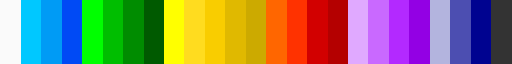

In [5]:
# 분포도 표출을 위한 라이브러리
import matplotlib.pyplot as plt

# 분포도 표출을 위한 색상표
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

# 레이더 강수량을 분포도로 표출하기 위해 25가지 색의 색상표를 RGB로 정의합니다.
colormap_rain = ListedColormap(np.array([
    [250, 250, 250], [0, 200, 255], [0, 155, 245], [0, 74, 245],                # 하늘색
    [0, 255, 0], [0, 190, 0], [0, 140, 0], [0, 90, 0],                          # 초록색
    [255, 255, 0], [255, 220, 31], [249, 205, 0], [224, 185, 0], [204, 170, 0], # 노랑색
    [255, 102, 0], [255, 50, 0], [210, 0, 0], [180, 0, 0],                      # 빨간색
    [224, 169, 255], [201, 105, 255], [179, 41, 255], [147, 0, 228],            # 보라색
    [179, 180, 222], [76, 78, 177], [0, 3, 144], [51, 51, 51]                   # 파란색
]) / 255)

# 색상표에서 NaN값은 투명한 색상(RGBA 중 A가 0)을 나타내도록 합니다.
colormap_rain.set_bad([0, 0, 0, 0])

# 색상표의 각각의 색이 나타내는 범위를 정한다.
bounds = np.array([
    0, 0.1, 0.5, 1, # 하늘색
    2, 3, 4, 5,     # 초록색
    6, 7, 8, 9, 10, # 노랑색
    15, 20, 25, 30, # 빨간색
    40, 50, 60, 70, # 보라색
    90, 110, 150    # 파란색
])

# 색상 개수와 값 범위를 서로 맞춥니다.
norm = BoundaryNorm(boundaries=bounds, ncolors=len(colormap_rain.colors))

# 색상표를 표출합니다.
colormap_rain

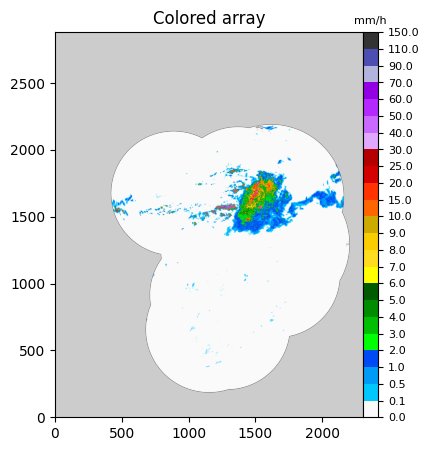

In [6]:
# 분포도에서 색상표 위치, 크기를 조절하는 함수
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 강수세기 배열 각각의 값을 색상표의 색이 나타내는 인덱스로 매핑시킵니다.
# 매핑된 각 인덱스 범위(0 ~ 25)를 정규화(0 ~ 1)합니다.
# 정규화를 통해 잃게된 투명색의 범위를 다시 지정합니다.
# 마지막으로 색상표의 색상으로 배열을 매핑합니다.
# 이때 배열의 형태를 (행 개수, 열 개수) 에서 (행 개수, 열 개수, RGBA)로 변환합니다.
colored_array = BoundaryNorm(
    boundaries=bounds,
    ncolors=len(colormap_rain.colors)
)(rain_rate)
colored_array = Normalize(
    0, len(colormap_rain.colors)
)(colored_array)
colored_array[null_mask] = np.nan
colored_array = (colormap_rain(colored_array) * 255).astype(np.uint8)

# 분포도에 표시되는 범위 값을 2칸 간격으로 구합니다.
ticks = bounds[:]

# 분포도를 그릴 크기를 지정합니다.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# 분포도의 제목을 지정합니다.
ax.set_title('Colored array')

# 배경색을 회색으로 지정합니다.
ax.set_facecolor('#cccccc')

# 색상표의 크기와 위치를 조절합니다.
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0)

# 배열을 해당 크기에 맞춰 그립니다.
im = ax.imshow(colored_array, origin='lower', cmap=colormap_rain, norm=norm)

# 색상표에 표시될 글자 크기 및 제목을 설정합니다.
cbar = fig.colorbar(im, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_title('mm/h', fontsize=8)

# 그린 이미지를 표출합니다.
plt.show()

위와 같은 이미지를 동적인 지도 위에 표출하기 전, 지도와 레이더 자료(이미지)의 ``좌표계(Coordinate Reference System, CRS)``를 맞추어야 합니다.

현재 동적인 지도가 사용하는 좌표계는 웹 상에서 지도를 표출할 때 많이 사용되는 ``EPSG:3857``입니다.

참고자료에 따르면 레이더 자료가 사용하는 좌표계는 ``Lambert Conformal Conic Projection(LCC)``으로 한반도를 중심으로 표현하기 적합해 여러 데이터에서도 사용된다고 합니다.

레이더 자료를 ``EPSG:3857``로 변환하여 지도 위에 표출합니다.

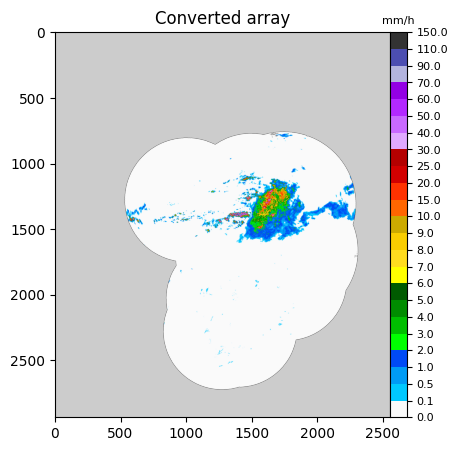

In [7]:
# 좌표계 변환을 위한 변환 행렬
from rasterio.transform import Affine

# 좌표계 변환을 위해 필요한 함수
from rasterio.warp import calculate_default_transform, reproject, Resampling

# 레이더 자료의 너비와 높이, 중심점 좌표와 공간 해상도를 m단위로 정의합니다.
source_width = nx
source_height = ny
source_center_x = 1121
source_center_y = 1681
source_resolution = 500

# 변환 전의 좌표계를 proj.4 형태의 문자열로 정의합니다.
# 투영법(Projection)은 LCC이며 LCC 좌표계 정의에 필요한 위도 선 2개(lat_1, lat_2)와
# 중심 위도, 경도(lat_0, lon_0)을 정의합니다.
# 좌표계의 x, y는 각각 오른쪽, 위로 증가하는 방향을 가지고(False easting, False northing)
# 지구 타원체를 WGS84로 정의합니다.
# 마지막으로 좌표계가 사용하는 단위는 미터(m)로 정의합니다.
source_crs = "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=38 +lon_0=126 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"

# 이미지(배열)의 행과 열이 LCC 좌표계에서의 좌표로 변환되기 위한 변환 행렬(Affine Transform Matrix)을 정의합니다.
# 변환 행렬은 먼저 이미지의 중심점을 (0, 0) 위치로 이동시킨 뒤(Translation)
# 각 이미지 픽셀이 실제로 500m를 나타내므로 크기를 x, y로 500배 키워주는(Scale) 역할을 합니다.
# 이때, 행렬의 곱하는 순서에 유의합니다.(AB != BA)
source_transform = Affine.scale(source_resolution, source_resolution) * Affine.translation(-source_center_x, -source_center_y)

# 변환 행렬을 거친 이미지가 나타내는 경계를 정의합니다.
source_bounds = {
    'left': -source_center_x * source_resolution,
    'bottom': (source_height - source_center_y) * source_resolution,
    'right': (source_width - source_center_x) * source_resolution,
    'top': -source_center_y * source_resolution
}

# 변환 후 이미지의 변환 행렬과 너비와 높이를 계산합니다.
dest_transform, dest_width, dest_height = calculate_default_transform(
    src_crs=source_crs,
    dst_crs='EPSG:3857',
    width=source_width,
    height=source_height,
    **source_bounds,
)

# 변환 후의 이미지가 담길 비어있는 배열을 정의합니다.
converted_array = np.ones((dest_height, dest_width, 4), dtype=np.uint8)

# RGBA 각 채널에 대해 좌표계 변환을 수행합니다.
# 사용하는 resampling 기법으로 가까운 값을 선택하는 nearest를 선택합니다.
for i in range(4):
    reproject(
        source=colored_array[:, :, i],
        destination=converted_array[:, :, i],
        src_transform=source_transform,
        src_crs=source_crs,
        dst_transform=dest_transform,
        dst_crs='EPSG:3857',
        resampling=Resampling.nearest,
    )

# 변환된 이미지를 분포도로 표출합니다.
# 이전 분포도와 다르게 원점의 위치, 너비, 높이가 달라졌음을 확인합니다.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# 분포도의 제목을 지정합니다.
ax.set_title('Converted array')

# 배경색을 회색으로 지정합니다.
ax.set_facecolor('#cccccc')

# 색상표의 크기와 위치를 조절합니다.
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0)

# 배열을 표출하며 정의한 색상표와 범위를 지정합니다.
im = ax.imshow(converted_array, cmap=colormap_rain, norm=norm)

# 색상표에 표시될 글자 크기 및 제목을 설정합니다.
cbar = fig.colorbar(im, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_title('mm/h', fontsize=8)

# 그린 이미지를 표출합니다.
plt.show()

마지막으로 변환된 이미지를 동적인 지도 위에 표출합니다.


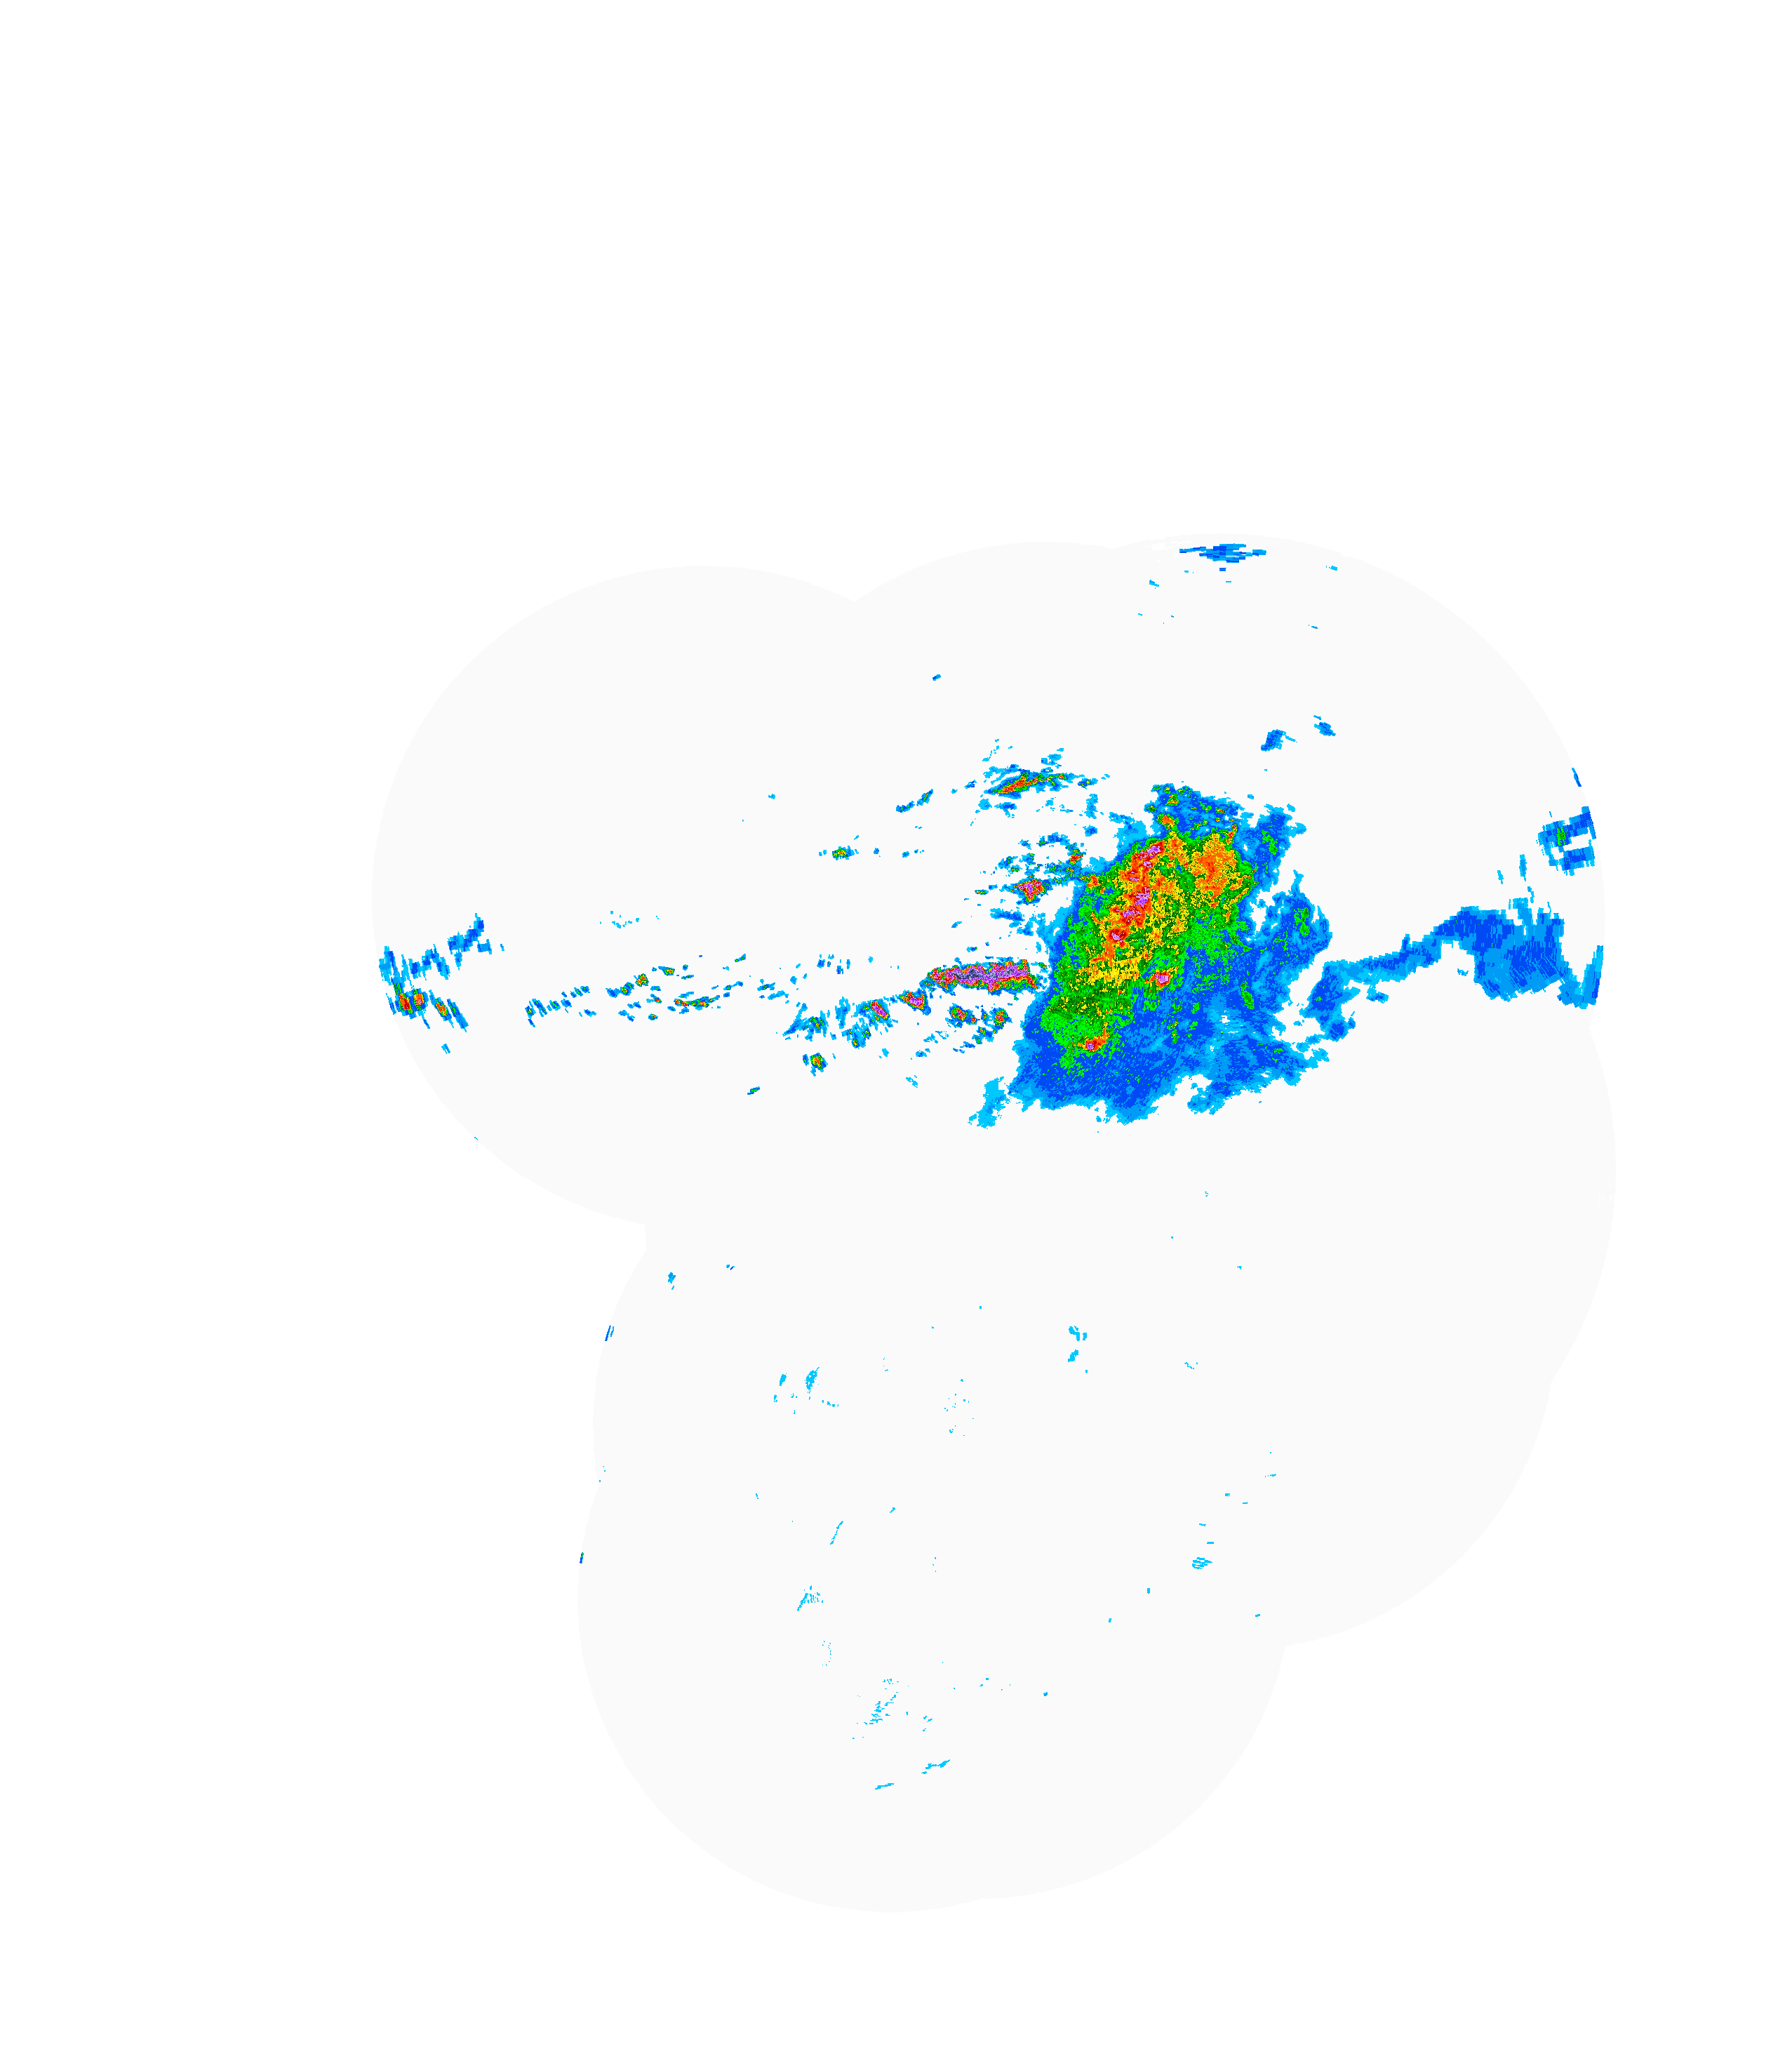

In [8]:
import folium   # 지도로 표출하기 위한 라이브러리
import branca.colormap as cm    # 지도에 색상표를 표출하기 위한 색상표 모듈

# 지도에 마우스 위치를 표출하는 플러그인
from folium.plugins import MousePosition

# 점끼리의 좌표계 변환을 위한 transformer
from pyproj.transformer import Transformer

# folium을 이용한 좌표는 경도, 위도만 입력 가능하므로
# EPSG:3857 좌표계에서 EPSG:4326 좌표계로의 변환하는 transformer를 정의합니다.
degree_tranformer = Transformer.from_crs('EPSG:3857', 'EPSG:4326')

# 너비, 높이 크기가 800인 지도 생성
fig = folium.Figure(width=800, height=800)

# 지도의 중심과 나타낼 영역을 위·경도로 입력합니다.
map = folium.Map(
    location=[38, 126],
    zoom_start=6,
    min_zoom=6,
    min_lat=28,
    max_lat=43,
    min_lon=116,
    max_lon=135,
    max_bounds=True,
).add_to(fig)

# 지도에 색상표를 추가합니다.
map.add_child(cm.StepColormap(
    [tuple(i) for i in colormap_rain.colors],
    vmin=bounds[0], vmax=bounds[-1], tick_labels=[], caption='mm/h'
))

# 변환된 이미지를 지도 위에 겹쳐 그립니다.
# 불투명도를 0.4로 정하고
# 이미지가 그려질 범위를 경도, 위도로 입력합니다.
folium.raster_layers.ImageOverlay(
    image=converted_array,
    name='rain_rate',
    opacity=0.4,
    bounds=[
        degree_tranformer.transform(*dest_transform.__mul__((0, dest_height))),
        degree_tranformer.transform(*dest_transform.__mul__((dest_width, 0)))
    ],
    zindex=1,
).add_to(map)

# 지도에 마우스 위치를 표출하는 플러그인과 layer를 조절하는 버튼을 추가합니다.
MousePosition().add_to(map)
folium.LayerControl().add_to(map)

# 지도를 표출합니다.
fig

In [9]:
# 지도 상에서 원하는 점의 위·경도를 알아낸뒤, 그 값을 인덱싱하여 가져올 수 있습니다.
# 예를 들어, 부산 해운대의 위·경도가 38.19192, 128.59634 이라면
# 그 지점의 좌표를 다시 LCC 좌표계로 변환하여 그 값을 가져올 수 있습니다.

# 위·경도 좌표계에서 LCC 좌표계로 변환하는 transformer를 정의합니다.
lcc_transformer = Transformer.from_crs('EPSG:4326', source_crs)

# 원하는 지점의 위·경도를 입력합니다.
target_lat = 38.19192
target_lon = 128.59634

# 위·경도 값을 LCC 좌표계로 변환합니다.
# source_transform 연산의 반대이므로 역행렬을 곱합니다.
index_col, index_row = source_transform.__invert__().__mul__(
    lcc_transformer.transform(target_lat, target_lon)
)

# 지점의 강수세기를 출력합니다.
print(
    f"위도 {target_lat}, 경도 {target_lon} 지점의 {time} 강수 세기는 "
    f"{rain_rate[round(index_row), round(index_col)]:.02f}mm/h 입니다."
)

위도 38.19192, 경도 128.59634 지점의 202208082000 강수 세기는 8.17mm/h 입니다.
